In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install seaborn
!pip install fastcluster

In [3]:
import sys

sys.path.append("/home/phil/mats_sae_training_jacob")

import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Compute distance/similarity metrics

In [4]:
sae = torch.load(
    "/home/phil/mlp_linearization/data/jacob_transcoder/final_sparse_autoencoder_gpt2-small_blocks.4.hook_mlp_out_24576.pt"
)
transcoder = torch.load(
    "/home/phil/mlp_linearization/data/jacob_transcoder/60002304_sparse_autoencoder_gpt2-small_blocks.4.ln2.hook_normalized_24576.pt"
)

In [5]:
sae["state_dict"].keys(), transcoder["state_dict"].keys()

(odict_keys(['W_enc', 'b_enc', 'W_dec', 'b_dec']),
 odict_keys(['W_enc', 'b_enc', 'W_dec', 'b_dec', 'b_dec_out']))

In [6]:
enc_t = transcoder["state_dict"]["W_enc"]
enc_s = sae["state_dict"]["W_enc"]

dec_t = transcoder["state_dict"]["W_dec"]
dec_s = sae["state_dict"]["W_dec"]

enc_t.shape, enc_s.shape, dec_t.shape, dec_s.shape

(torch.Size([768, 24576]),
 torch.Size([768, 24576]),
 torch.Size([24576, 768]),
 torch.Size([24576, 768]))

In [7]:
prods_ed = (enc_t @ dec_s).cpu().numpy()
prods_ee = (enc_t.T @ enc_s).cpu().numpy()

# Histograms

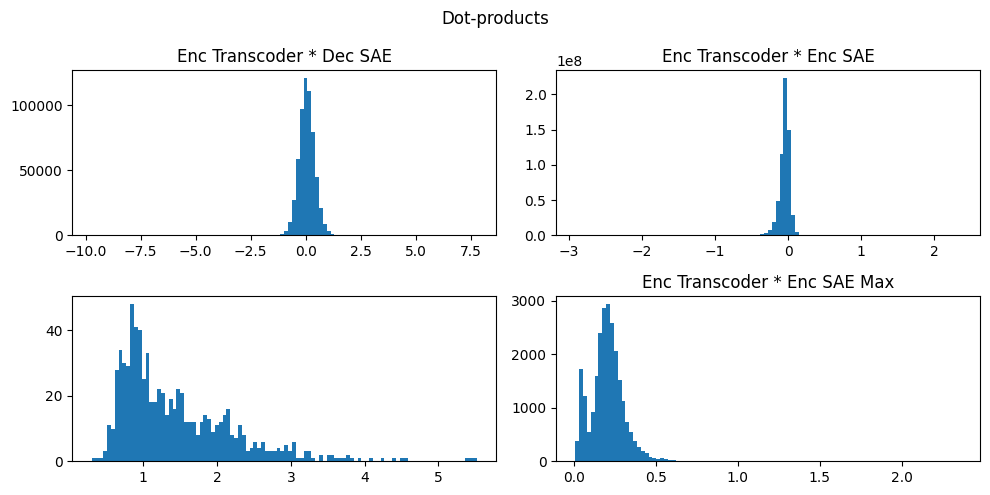

In [8]:
def plot_ee_ed(ee, ed, take_max=True):
    if isinstance(ee, torch.Tensor):
        ee = ee.cpu().numpy()
    if isinstance(ed, torch.Tensor):
        ed = ed.cpu().numpy()

    fig, axs = plt.subplots(2, 2, figsize=(10, 5))

    axs[0, 0].hist(ed.flatten(), bins=100)
    axs[0, 0].set_title("Enc Transcoder * Dec SAE")

    axs[0, 1].hist(ee.flatten(), bins=100)
    axs[0, 1].set_title("Enc Transcoder * Enc SAE")

    if take_max:
        axs[1, 0].hist((ed - np.diag(ed.diagonal())).max(axis=1).flatten(), bins=100)
        axs[1, 1].set_title("Enc Transcoder * Enc SAE Max")
    else:
        axs[1, 0].hist((ed + np.diag(np.inf * np.ones(ed.shape[0]))).min(axis=1).flatten(), bins=100)
        axs[1, 0].set_title("Enc Transcoder * Dec SAE Min")

    if take_max:
        axs[1, 1].hist((ee - np.diag(ee.diagonal())).max(axis=1).flatten(), bins=100)
        axs[1, 1].set_title("Enc Transcoder * Enc SAE Max")
    else:
        axs[1, 1].hist((ee + np.diag(np.inf * np.ones(ee.shape[0]))).min(axis=1).flatten(), bins=100)
        axs[1, 1].set_title("Enc Transcoder * Enc SAE Min")

    return fig, axs


fig, axs = plot_ee_ed(prods_ee, prods_ed)
fig.suptitle("Dot-products")
fig.tight_layout()

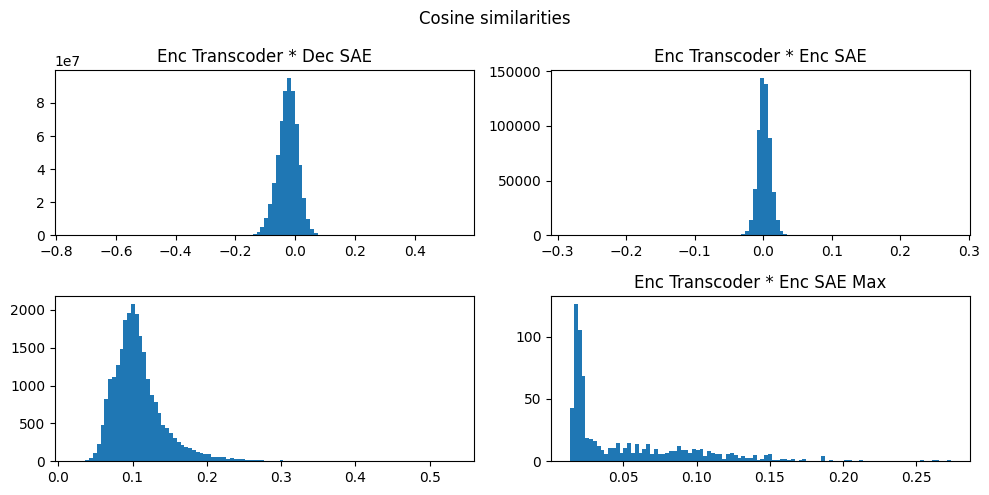

In [9]:
# Same thing but with cossims

sims_ed = (
    (enc_t @ dec_s / (torch.linalg.norm(enc_t, axis=1)[:, None] * torch.linalg.norm(dec_s, axis=0)[None, :]))
    .cpu()
    .numpy()
)
sims_ee = (
    (enc_t.T @ enc_s / (torch.linalg.norm(enc_t.T, axis=1)[:, None] * torch.linalg.norm(enc_s, axis=0)[None, :]))
    .cpu()
    .numpy()
)

fig, axs = plot_ee_ed(sims_ed, sims_ee)
fig.suptitle("Cosine similarities")
fig.tight_layout()

(24576, 24576) (24576, 24576)


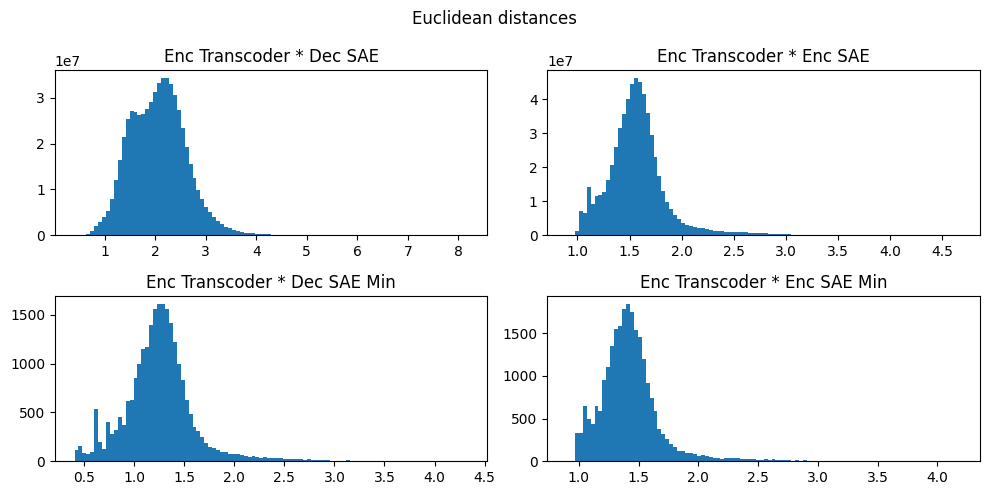

In [10]:
# Get distances between vectors instead

dists_ed = torch.cdist(enc_t.T, dec_s).cpu().numpy()
dists_ee = torch.cdist(enc_t.T, enc_s.T).cpu().numpy()

print(dists_ed.shape, dists_ee.shape)

fig, axs = plot_ee_ed(dists_ed, dists_ee, take_max=False)
fig.suptitle("Euclidean distances")
fig.tight_layout()

# Dendrograms

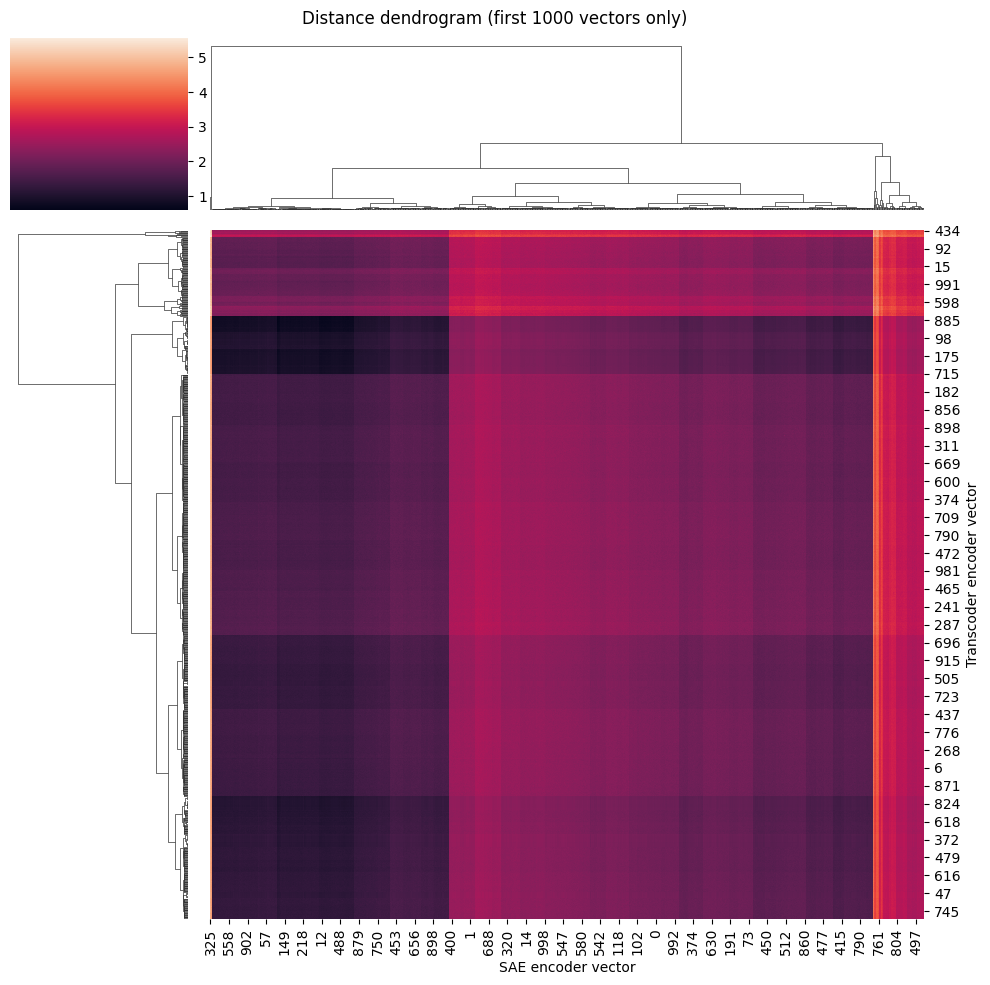

In [31]:
# Heatmap with dendrogram

N = 1000
clust = sns.clustermap(dists_ee[:N, :N], row_cluster=True, col_cluster=True)

# Label
clust.ax_heatmap.set_xlabel("SAE encoder vector")
clust.ax_heatmap.set_ylabel("Transcoder encoder vector")
plt.suptitle(f"Distance dendrogram (first {N} vectors only)")

plt.tight_layout()
plt.show()

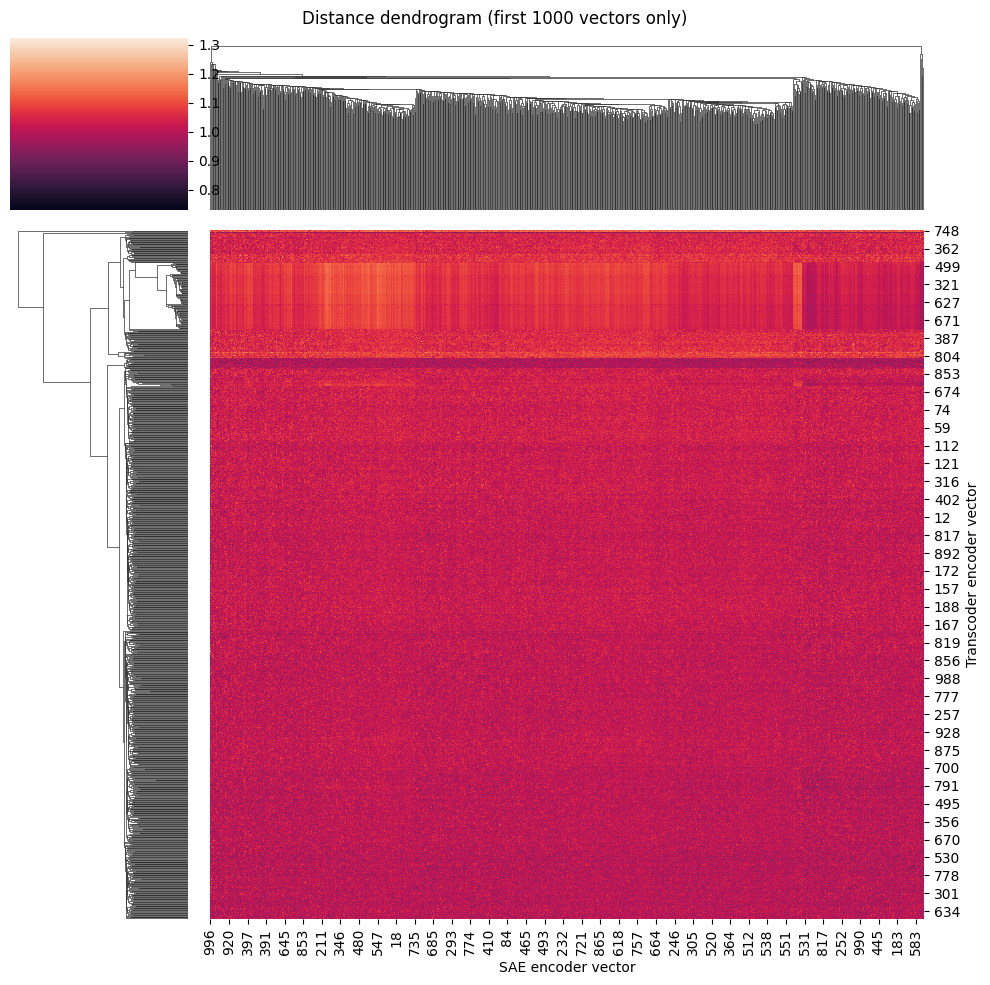

In [32]:
# Heatmap with dendrogram

N = 1000
clust = sns.clustermap(1 - sims_ee[:N, :N], row_cluster=True, col_cluster=True)

# Label
clust.ax_heatmap.set_xlabel("SAE encoder vector")
clust.ax_heatmap.set_ylabel("Transcoder encoder vector")
plt.suptitle(f"Distance dendrogram (first {N} vectors only)")

plt.tight_layout()
plt.show()

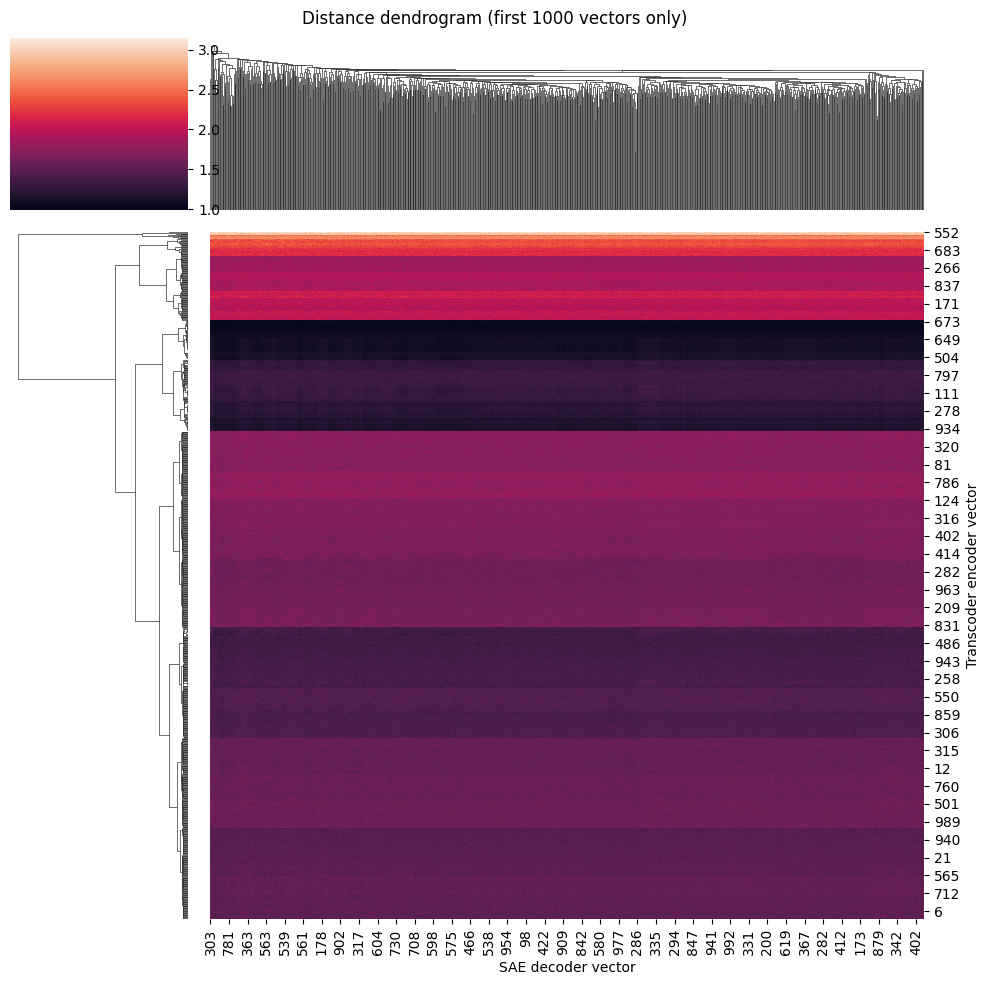

In [12]:
# Heatmap with dendrogram

clust = sns.clustermap(dists_ed[:N, :N], row_cluster=True, col_cluster=True)

# Label
clust.ax_heatmap.set_xlabel("SAE decoder vector")
clust.ax_heatmap.set_ylabel("Transcoder encoder vector")
plt.suptitle(f"Distance dendrogram (first {N} vectors only)")

plt.tight_layout()
plt.show()

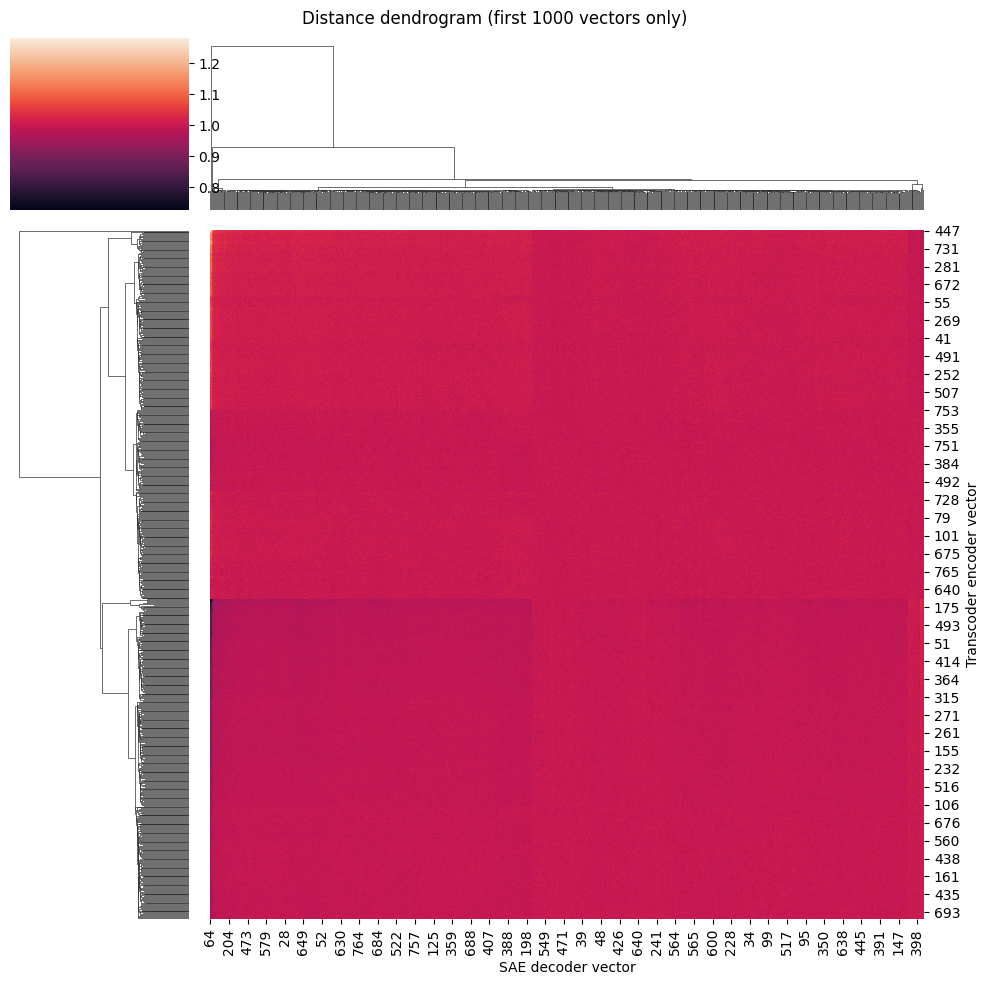

In [30]:
# Heatmap with dendrogram

clust = sns.clustermap(1 - sims_ed[:N, :N], row_cluster=True, col_cluster=True)

# Label
clust.ax_heatmap.set_xlabel("SAE decoder vector")
clust.ax_heatmap.set_ylabel("Transcoder encoder vector")
plt.suptitle(f"Distance dendrogram (first {N} vectors only)")

plt.tight_layout()
plt.show()

# Is there something going on with the transcoder encoder vectors in particular?

(24576, 24576) (24576, 24576)


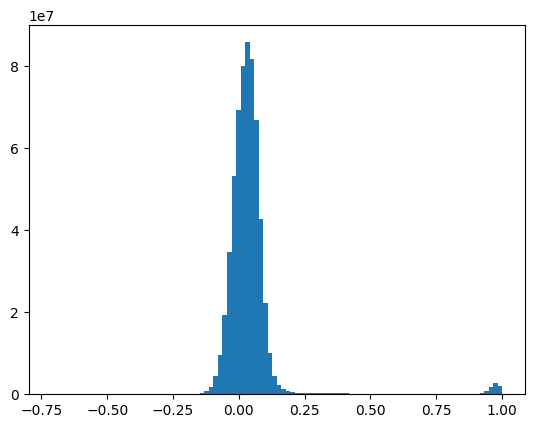

In [26]:
# Get distances between vectors instead

# transcoder_dists = torch.cdist(enc_t, enc_t).cpu().numpy()
transcoder_dists = (
    enc_t.T @ enc_t / (torch.linalg.norm(enc_t.T, axis=1)[:, None] * torch.linalg.norm(enc_t, axis=0)[None, :])
).cpu().numpy()


print(dists_ed.shape, dists_ee.shape)
plt.hist(transcoder_dists.flatten(), bins=100)
plt.show()

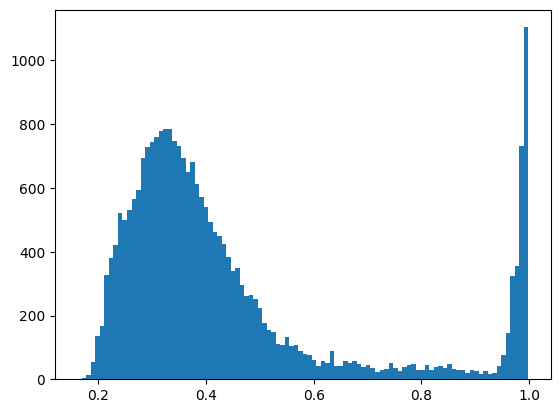

In [28]:
plt.hist(
    # (transcoder_dists + np.diag(np.inf * np.ones(transcoder_dists.shape[0]))).min(axis=1).flatten(),
    (transcoder_dists - np.diag(transcoder_dists.diagonal())).max(axis=1).flatten(),
    bins=100
)
plt.show()

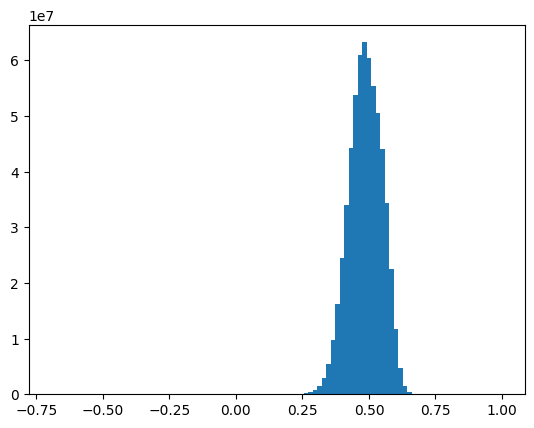

In [33]:
# sae_dists = torch.cdist(enc_s, enc_s).cpu().numpy()
sae_dists = (
    enc_s.T @ enc_s / (torch.linalg.norm(enc_s.T, axis=1)[:, None] * torch.linalg.norm(enc_s, axis=0)[None, :])
).cpu().numpy()

plt.hist(sae_dists.flatten(), bins=100)
plt.show()


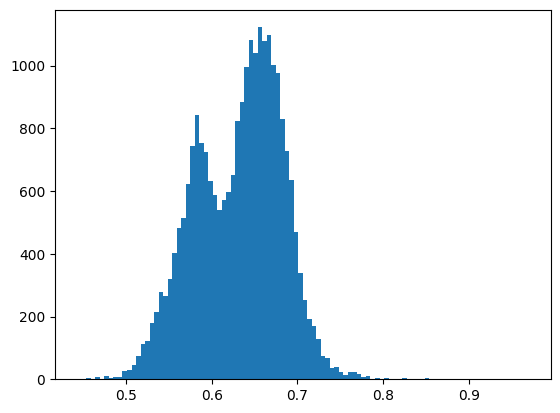

In [34]:
plt.hist(
    # (sae_dists + np.diag(np.inf * np.ones(sae_dists.shape[0]))).min(axis=1).flatten(), 
    (sae_dists - np.diag(sae_dists.diagonal())).max(axis=1).flatten(),
    bins=100
)
plt.show()